In [1]:
import functools
import numpy as np
np.random.seed(666)
import random
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path = '../DBSCAN_Points.txt'
data = np.loadtxt(path)

In [3]:
class DBSCAN:
    
    def __init__(self,eps,MinPts):
        self.eps = eps
        self.MinPts = MinPts
    
    def distance_matrix(self):
        """
        Compute n x n distance matrix 
        
        Refers from https://stackoverflow.com/questions/22720864/efficiently-calculating-a-euclidean-distance-matrix-using-numpy
        """
        self.distance_matrix = np.sqrt(np.sum((self.data[:, np.newaxis, :] - self.data[np.newaxis, :, :]) ** 2, axis = -1))
        
    def get_neighbor(self):
        """
        return dict of eps-neighbor for each data point
        """
        eps_neighbor = np.where(self.distance_matrix <= self.eps) #get eps-neighbor from distance matrix
        eps_neighbor = list(zip(eps_neighbor[0],eps_neighbor[1])) #zip to create dict
        point_neighbor = {}
        for item in eps_neighbor: #process of create dict key:value = poing : list of neighbors
            if point_neighbor.get(item[0]) == None:
                point_neighbor[item[0]] = [item[1]]
            else:
                point_neighbor[item[0]].append(item[1])
        self.neighbor = point_neighbor 
    
    def identify_points(self):
        """
        Classify points to noise (-1), boarder point(0), core point(1)
        """
        id_list = np.array([-1] * self.n) #id_list, default to noise point
        
        core_point_index = []
        for key in self.neighbor.keys():
            if len(self.neighbor[key]) >= self.MinPts: #if it is core point
                id_list[key] = 1
                core_point_index.append(key)
                
        for key in self.neighbor.keys():
            if len(self.neighbor[key]) < self.MinPts: #if it is not core point
                if set(self.neighbor[key]) & set(core_point_index) != set(): #but contains core point in neighbor
                    id_list[key] = 0
        
        self.id_list = id_list
    
    def density_reachable(self,x):
        """
        Compute all points are density reachable from x
        """
        index = []
        
        queue = list() #create a queue, similar to DFS
        queue.append(x)
        
        while len(queue)>0:
            tmp = queue.pop(0) #get the first point
            index.append(tmp)
            if self.id_list[tmp] == 1:
                neighbors = self.neighbor[tmp] #get neighbors
                queue.extend([neighbor for neighbor in neighbors if neighbor not in index]) #points which are core point will be appended
                index.extend([neighbor for neighbor in neighbors if neighbor not in index]) #points which are core point will be appended
        return index
                
        
    def fit(self,data):
        """
        Entry of DBSCAN
        """
        self.data = data
        n = data.shape[0] #len of data
        self.n = n
        self.index = range(n) #index of data
        
        self.distance_matrix() #compute distance matrix
        
        self.get_neighbor() #compute neighbor dictionary
                                                
        self.identify_points()# classify points
    
        labels = [-1] * self.n #label of each points
        cluster_id = 0
        
        shuffle_index = list(self.index) 
        random.shuffle(shuffle_index) #shuffle list to simulate arbitary taking points from database
        
        while len(shuffle_index) > 0: #while there are points not processed
            p = shuffle_index[0]
            if self.id_list[p] == 1: #if it is a core point
                index = self.density_reachable(p)
                for i in index:
                    labels[i] = cluster_id
                    if i in shuffle_index: # point is density reachable from p may be removed before
                        shuffle_index.remove(i)
                cluster_id += 1
                
            else: #if it is not a core point, just mark processed
                shuffle_index.remove(p)
        
        self.labels = labels
    
    def plot(self):
        """
        plot the result
        """
        df = pd.DataFrame(self.data)
        
        df['Label'] = self.labels
        
        
        fig = plt.figure(figsize=(6,4),dpi=200)
        plt.scatter(df[0], df[1], c=df['Label'])
        plt.scatter(df[df['Label']==-1][0],df[df['Label']==-1][1],color='black')

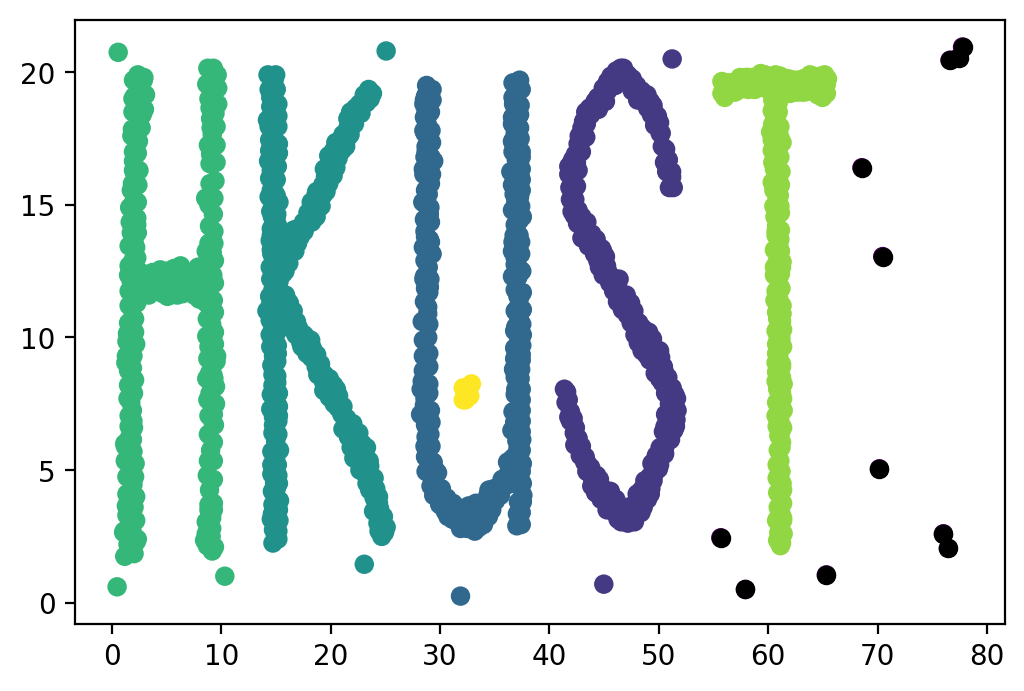

In [4]:
dbscan = DBSCAN(eps = 3, MinPts = 5)
dbscan.fit(data)
dbscan.plot()

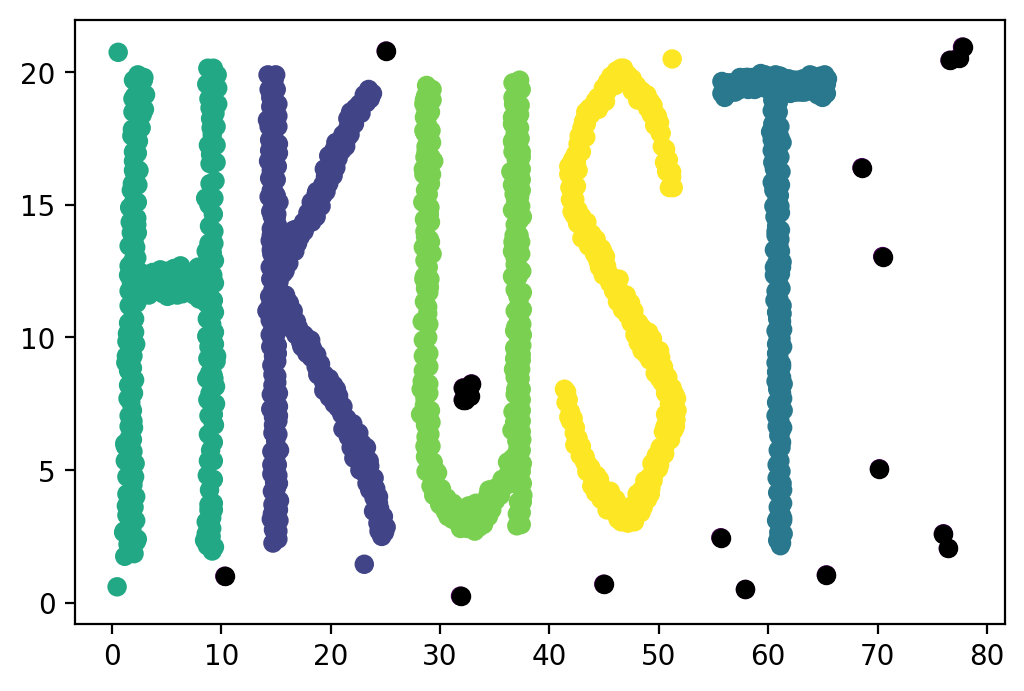

In [5]:
dbscan = DBSCAN(eps = 2.5, MinPts = 20)
dbscan.fit(data)
dbscan.plot()

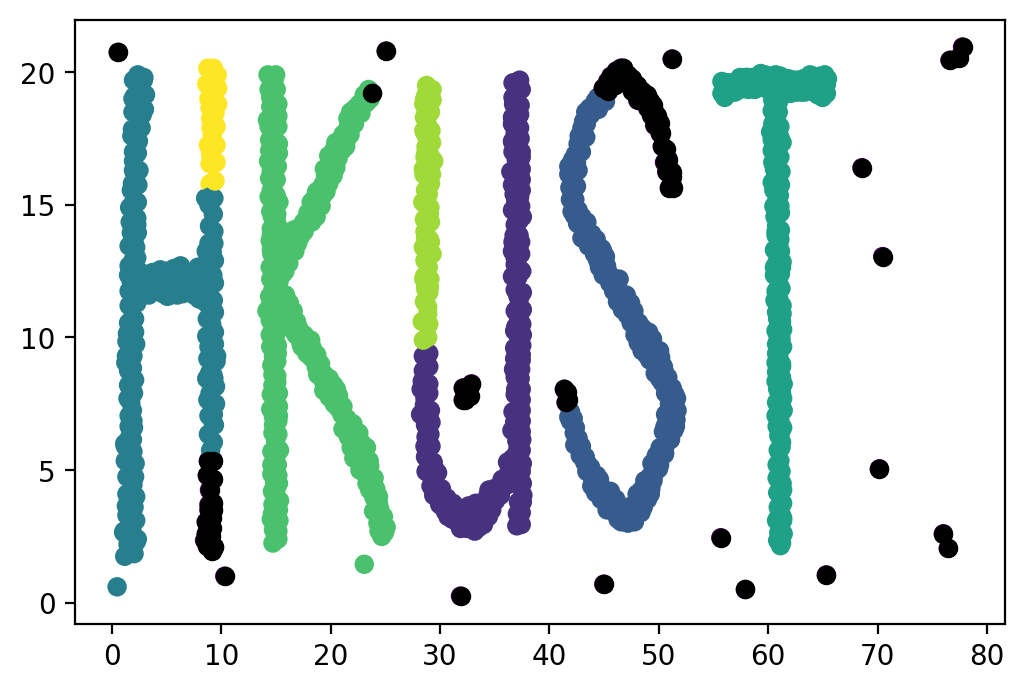

In [6]:
dbscan = DBSCAN(eps = 2, MinPts = 20)
dbscan.fit(data)
dbscan.plot()

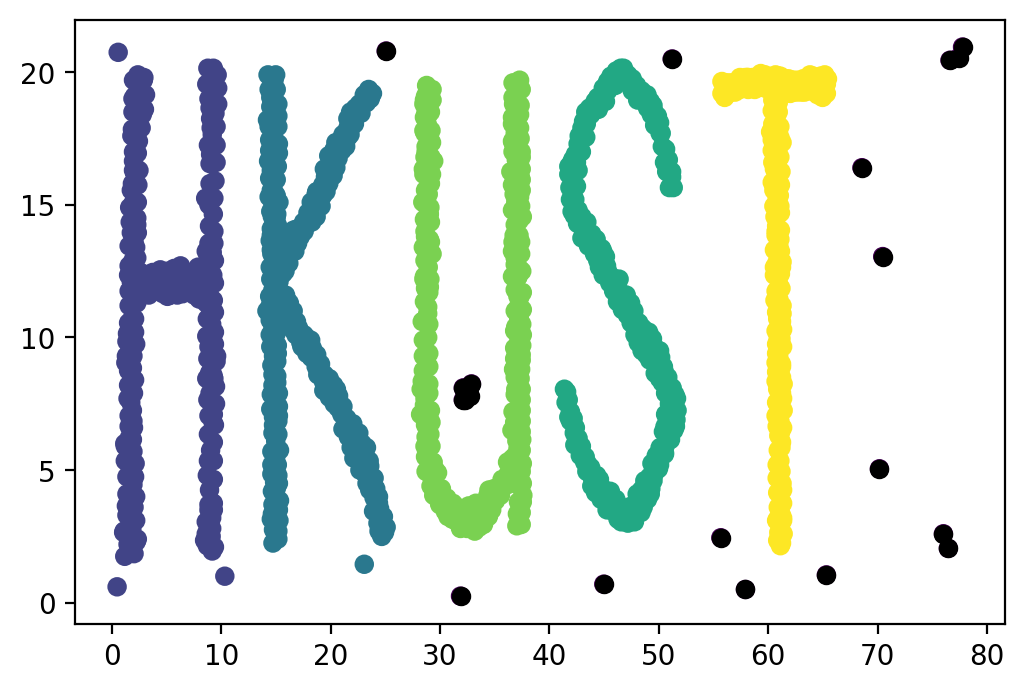

In [7]:
dbscan = DBSCAN(eps = 2, MinPts = 15)
dbscan.fit(data)
dbscan.plot()